In [1]:
import os
import scanpy as sc
from os.path import join

from spamosaic.framework import SpaMosaic

In [2]:
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # for CuBLAS operation and you have CUDA >= 10.2
import spamosaic.utils as utls
from spamosaic.preprocessing import RNA_preprocess, ADT_preprocess, Epigenome_preprocess

In [3]:
data_dir = './data/Human_lymph_node'

ad1_rna = sc.read_h5ad(join(data_dir, 'slice1/s1_adata_rna.h5ad'))
ad1_adt = sc.read_h5ad(join(data_dir, 'slice1/s1_adata_adt.h5ad'))
ad2_rna = sc.read_h5ad(join(data_dir, 'slice2/s2_adata_rna.h5ad'))
ad3_adt = sc.read_h5ad(join(data_dir, 'slice3/s3_adata_adt.h5ad'))

### preprocessing

In [4]:
input_dict = {
    'rna': [ad1_rna, ad2_rna, None],
    'adt': [ad1_adt, None,    ad3_adt]
}

input_key = 'dimred_bc'

In [5]:
RNA_preprocess(input_dict['rna'], batch_corr=True, favor='scanpy', n_hvg=5000, batch_key='src', key=input_key)
ADT_preprocess(input_dict['adt'], batch_corr=True, batch_key='src', key=input_key)

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).
Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


### training

In [6]:
model = SpaMosaic(
    modBatch_dict=input_dict, input_key=input_key,
    batch_key='src', 
    intra_knns=10, inter_knn_base=10, 
    w_g=0.8,
    seed=1234, 
    device='cpu'
)

model.train(net='wlgcn', lr=0.01, T=0.01, n_epochs=100)

batch0: ['rna', 'adt']
batch1: ['rna']
batch2: ['adt']
------Calculating spatial graph...
The graph contains 34840 edges, 3484 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 33590 edges, 3359 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 34840 edges, 3484 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 34080 edges, 3408 cells.
10.0000 neighbors per cell on average.
Searching MNN within rna
Finding MNN between (s1, s2) using KNN (10, 10)
Number of mnn pairs for rna:8370
Searching MNN within adt
Finding MNN between (s1, s3) using KNN (10, 10)
Number of mnn pairs for adt:11255


100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.73it/s]


In [7]:
ad_embs = model.infer_emb(input_dict, emb_key='emb', final_latent_key='merged_emb')
ad_mosaic = sc.concat(ad_embs)
ad_mosaic = utls.get_umap(ad_mosaic, use_reps=['merged_emb'])

/home/yanxh/anaconda3/envs/spamosaic-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


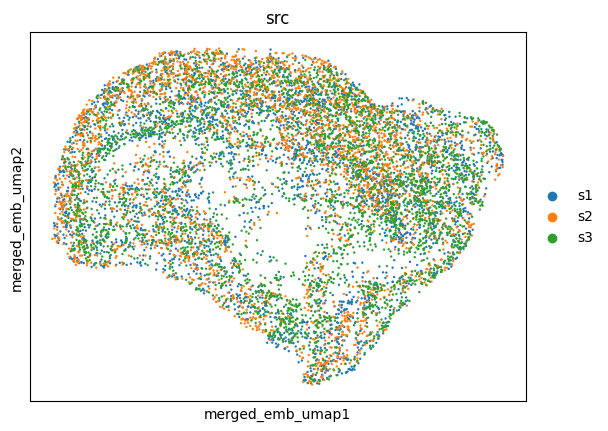

In [8]:
utls.plot_basis(ad_mosaic, basis='merged_emb_umap', color=['src'])

### clustering

In [9]:
utls.clustering(ad_mosaic, n_cluster=10, used_obsm='merged_emb', algo='mclust', key='mclust')
utls.split_adata_ob(ad_embs, ad_mosaic, 'obs', 'mclust')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


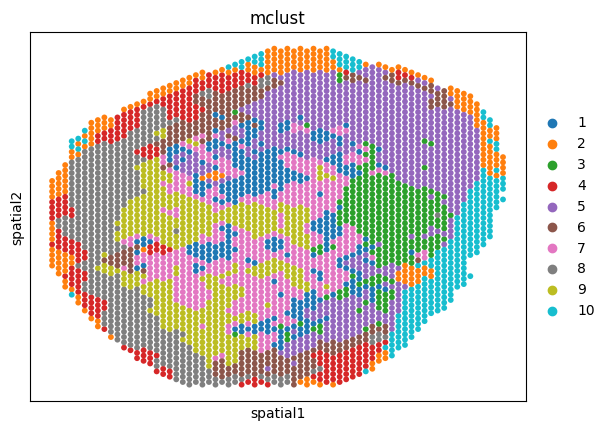

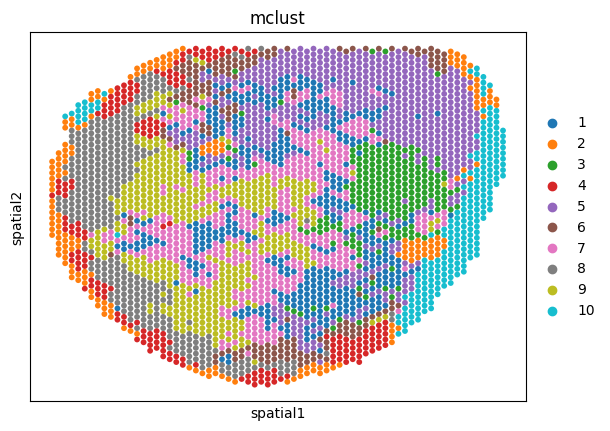

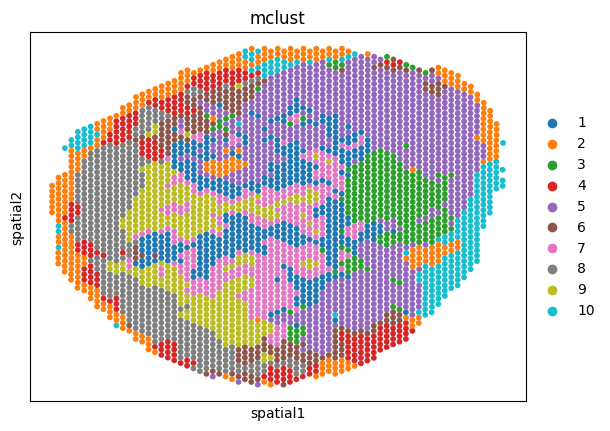

In [10]:
for ad in ad_embs:
    utls.plot_basis(ad, 'spatial', 'mclust', s=70)

### Imputation

In [11]:
for mod, ads in input_dict.items():
    for ad in ads:
        if ad is not None:
            ad.layers['counts'] = ad.X.copy()  # set targeting layers

In [12]:
imputed_featureDict = model.impute(input_dict, emb_key='emb', layer_key='counts', imp_knn=10)

impute adt-counts for batch-2
impute rna-counts for batch-3


In [13]:
imputed_featureDict

{'rna': [None,
  None,
  array([[0. , 0. , 0. , ..., 0. , 1.7, 0.6],
         [0.1, 0.1, 0.2, ..., 0.2, 0.8, 1. ],
         [0.1, 0.1, 0. , ..., 0.1, 1.3, 0.8],
         ...,
         [0. , 0.1, 0.2, ..., 0.6, 4.4, 1.8],
         [0. , 0.1, 0. , ..., 0.2, 1.2, 0.1],
         [0. , 0. , 0. , ..., 0. , 1.5, 1.9]], dtype=float32)],
 'adt': [None,
  array([[27780.7, 24925. ,  7825.6, ..., 27155.9, 17384.6,  1433.4],
         [35680.6, 15681.2, 14993.9, ..., 23766.6, 20022.6,  2313. ],
         [36030.6, 16018.1, 12367.3, ..., 21489. , 17672.7,  2026.9],
         ...,
         [27600.6, 28243.9,  7298.4, ..., 34580.5, 23055.1,  1530.6],
         [37230.1, 22585.6,  7802.7, ..., 36332.7, 24952.6,  2466.7],
         [26005. , 20562.2,  7445.2, ..., 30774.1, 20101.9,  1767.1]]),
  None]}